Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             5000      
_________________________________________________________________
reshape (Reshape)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 8,406
Trainable params: 8,406
Non-trainable params: 0
_________________________________________________________________


**********************************
Episode: 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
**********************************
reward is :
-1


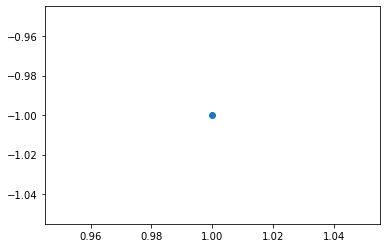

**********************************
Episode: 2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
**********************************
reward is :
2


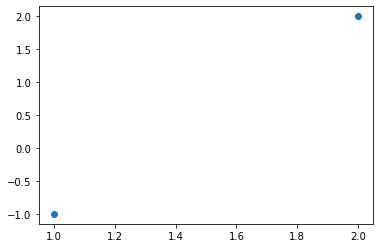

**********************************
Episode: 3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
**********************************
reward is :
2


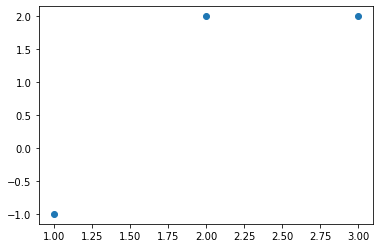

**********************************
Episode: 4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| |_: | : |
|Y| : |B: |
+---------+
  (South)
**********************************
reward is :
-1


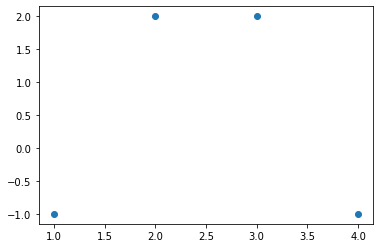

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from drawnow import drawnow
from IPython.display import clear_output
from collections import deque
import progressbar

import gym
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam


def makeFig():
    plt.scatter(xList,yList) # I think you meant this
plt.ion() # enable interactivity
fig=plt.figure() # make a figure

xList=list()
yList=list()
#make environment
enviroment = gym.make("Taxi-v3").env
#enviroment.render()
#print('Number of states: {}'.format(enviroment.observation_space.n))
#print('Number of actions: {}'.format(enviroment.action_space.n))

#agent class
class Agent:
    def __init__(self, enviroment, optimizer):

        # Initialize atributes
        self._state_size = enviroment.observation_space.n
        self._action_size = enviroment.action_space.n
        self._optimizer = optimizer

        self.expirience_replay = deque(maxlen=2000)#random sample

        # Initialize discount and exploration rate/ hyper parameters
        self.gamma = 0.7 #discounting rate
        self.epsilon = 0.3

        # Build networks
        self.q_network = self._build_compile_model()
        self.target_network = self._build_compile_model()
        self.alighn_target_model()

    def store(self, state, action, reward, next_state, terminated):
        self.expirience_replay.append((state, action, reward, next_state, terminated))

    def _build_compile_model(self):#core
        model = Sequential()
        model.add(Embedding(self._state_size, 10, input_length=1))
        model.add(Reshape((10,)))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(self._action_size, activation='linear'))
        model.compile(loss='mse', optimizer=self._optimizer)
        return model

    def alighn_target_model(self):#set parameter to tar_get network
        self.target_network.set_weights(self.q_network.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return enviroment.action_space.sample()
        q_values = self.q_network.predict(state)
        return np.argmax(q_values[0])

    def retrain(self, batch_size):#retrain from experience memory
        minibatch = random.sample(self.expirience_replay, batch_size)

        for state, action, reward, next_state, terminated in minibatch:

            target = self.q_network.predict(state)

            if terminated:
                target[0][action] = reward
            else:
                t = self.target_network.predict(next_state)
                target[0][action] = reward + self.gamma * np.amax(t)

            self.q_network.fit(state, target, epochs=1, verbose=0)


optimizer = Adam(learning_rate=0.01)
agent = Agent(enviroment, optimizer)

batch_size = 32
num_of_episodes = 50
timesteps_per_episode = 100
agent.q_network.summary()
for e in range(0, num_of_episodes):
    # Reset the enviroment
    state = enviroment.reset()
    state = np.reshape(state, [1, 1])

    # Initialize variables
    reward = 0
    terminated = False


    bar = progressbar.ProgressBar(maxval=timesteps_per_episode/10, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    for timestep in range(timesteps_per_episode):
        # Run Action
        action = agent.act(state)

        # Take action
        next_state, reward, terminated, info = enviroment.step(action)
        next_state = np.reshape(next_state, [1, 1])
        agent.store(state, action, reward, next_state, terminated)

        state = next_state
        reward += action

        if terminated:
            agent.alighn_target_model()
            break

        if len(agent.expirience_replay) > batch_size:
            agent.retrain(batch_size)

        if timestep%10 == 0:
            bar.update(timestep/10 + 1)

    bar.finish()
    print("**********************************")
    print("Episode: {}".format(e + 1))
    enviroment.render()
    print("**********************************")
    print("reward is :")
    y = reward
    print(reward)
    xList.append(e+1)
    yList.append(y)
    drawnow(makeFig)
agent.q_network.summary()

    



